In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
from transformers import SwinModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or any size you prefer)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

#Import Dataset
dataset = datasets.CIFAR100('.',download=True, transform=transform)

# Triplet Dataset Class
class TripletCIFAR100(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset

    def __getitem__(self, index):
        anchor, label = self.cifar_dataset[index]
        positive_index = index
        while positive_index == index:
            positive_index = torch.randint(len(self.cifar_dataset), (1,)).item()
        negative_index = torch.randint(len(self.cifar_dataset), (1,)).item()
        anchor, label = self.cifar_dataset[index]
        positive, _ = self.cifar_dataset[positive_index]
        negative, _ = self.cifar_dataset[negative_index]
        return anchor, positive, negative, label

    def __len__(self):
        return len(self.cifar_dataset)

triplet_dataset = TripletCIFAR100(dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 169M/169M [00:05<00:00, 31.8MB/s]


Extracting .\cifar-100-python.tar.gz to .


In [ ]:
train_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

# Model

In [ ]:
#Configure Model
#swinmodel = models.swin_v2_s(pretrained=True)
swinmodel = models.swin_v2_s(weights='IMAGENET1K_V1')
swinmodel.head = nn.Identity() # Remove the classification layer
#swinmodel.eval()

# Define Loss function
class TripletLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2)
  def forward(self, anchor, positive, negative):
    return self.loss_fn(anchor,positive, negative)

# Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
swinmodel = swinmodel.to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(swinmodel.parameters(), lr=0.001)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

def train(model, criterion, optimizer, dataloader, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            anchor, positive, negative, _ = data
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                anchor_features = model(anchor)
                positive_features = model(positive)
                negative_features = model(negative)
                loss = criterion(anchor_features, positive_features, negative_features)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if i % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}], Loss: {loss.item():.4f}')

    # Save the model and optimizer state dictionaries
    save_dir = './saved_models'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, 'swinmodel.pth')
    optimizer_path = os.path.join(save_dir, 'optimizer.pth')

    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)

    print(f'Model saved to {model_path}')
    print(f'Optimizer state saved to {optimizer_path}')

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to C:\Users\luvia/.cache\torch\hub\checkpoints\swin_v2_s-637d8ceb.pth
100%|███████████████████████████████████████████████████████████████████████████████| 191M/191M [00:04<00:00, 44.4MB/s]
C:\Users\luvia\AppData\Local\Temp\ipykernel_22300\1410119342.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
train(swinmodel, criterion, optimizer, train_loader, device)

C:\Users\luvia\AppData\Local\Temp\ipykernel_22300\1410119342.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/5], Step [1], Loss: 0.7820
Epoch [1/5], Step [11], Loss: 1.5613
Epoch [1/5], Step [21], Loss: 1.7162
Epoch [1/5], Step [31], Loss: 1.6294
Epoch [1/5], Step [41], Loss: 2.3547
Epoch [1/5], Step [51], Loss: 1.9107
Epoch [1/5], Step [61], Loss: 0.9352
Epoch [1/5], Step [71], Loss: 1.6212
Epoch [1/5], Step [81], Loss: 2.6597
Epoch [1/5], Step [91], Loss: 1.5639
Epoch [1/5], Step [101], Loss: 1.4829
Epoch [1/5], Step [111], Loss: 1.1094
Epoch [1/5], Step [121], Loss: 1.4890
Epoch [1/5], Step [131], Loss: 1.0306
Epoch [1/5], Step [141], Loss: 2.2546
Epoch [1/5], Step [151], Loss: 1.3733
Epoch [1/5], Step [161], Loss: 2.3745
Epoch [1/5], Step [171], Loss: 0.8852
Epoch [1/5], Step [181], Loss: 1.8076
Epoch [1/5], Step [191], Loss: 1.8945
Epoch [1/5], Step [201], Loss: 1.1386
Epoch [1/5], Step [211], Loss: 1.2627
Epoch [1/5], Step [221], Loss: 1.1052
Epoch [1/5], Step [231], Loss: 1.0061
Epoch [1/5], Step [241], Loss: 1.0343
Epoch [1/5], Step [251], Loss: 1.9421
Epoch [1/5], Step [261]

In [ ]:
# Evaluation

C:\Users\luvia\AppData\Local\Temp\ipykernel_22300\3839611947.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))
C:\Us

Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\luvia\.conda\envs\torch1.12\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\luvia\.conda\envs\torch1.12\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Computation Time: 141.4641 seconds
Memory Allocated: 608.36 MB
Memory Reserved: 16540.00 MB


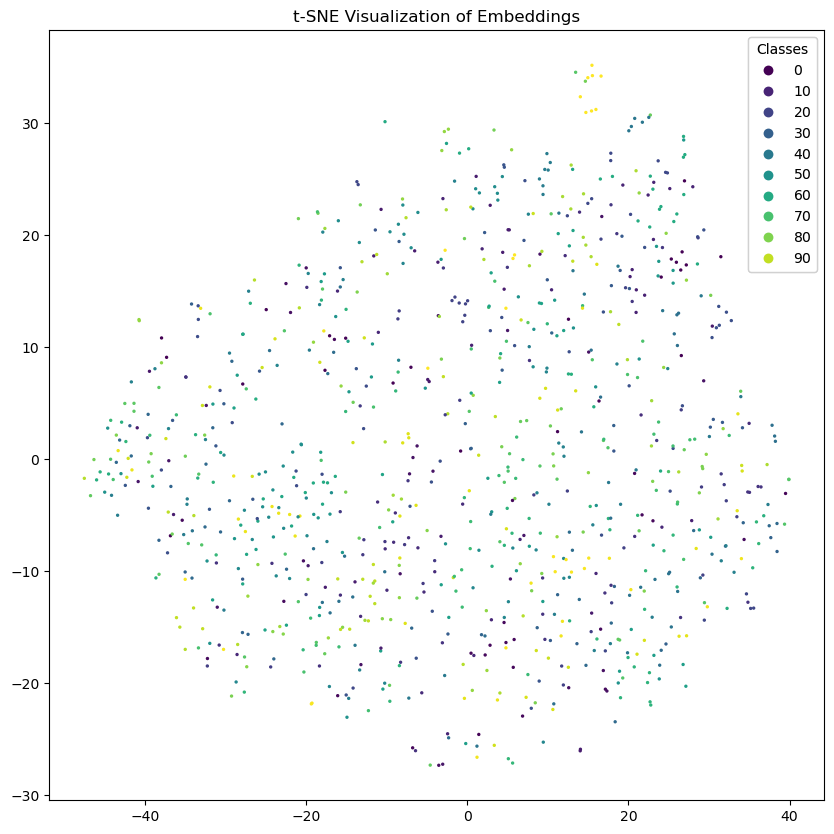

Are the weights of the first convolutional layer equal? True
Maximum difference between the weights: 0.0


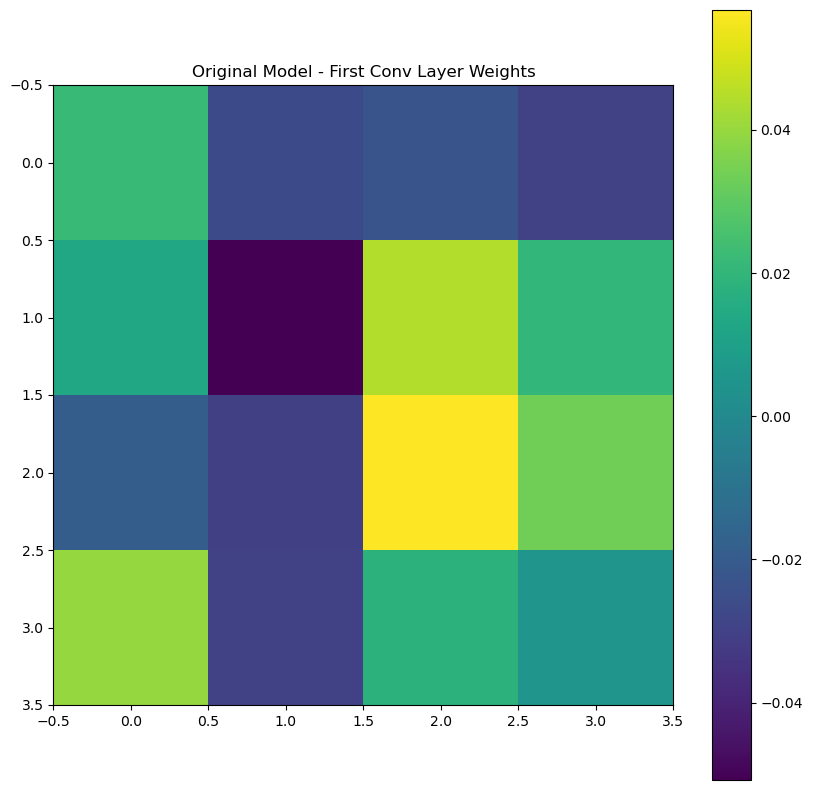

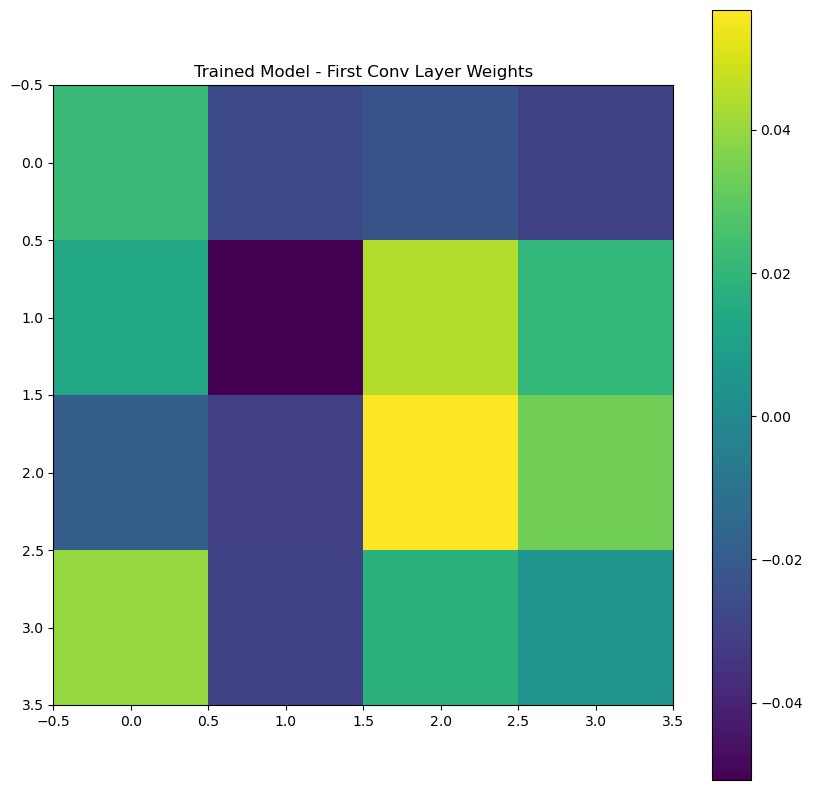

In [ ]:
# Load the original pre-trained model
original_model = models.swin_v2_s(weights='IMAGENET1K_V1')

# Load the trained model
trained_model = models.swin_v2_s(weights='IMAGENET1K_V1')
trained_model.head = nn.Identity()  # Remove the classification layer

# Load the model state dictionary for the trained model
model_path = './saved_models/swinmodel.pth'
trained_model.load_state_dict(torch.load(model_path))

# Load the optimizer state dictionary (optional)
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)
optimizer_path = './saved_models/optimizer.pth'
optimizer.load_state_dict(torch.load(optimizer_path))

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

# Create a subset of 1000 images from the CIFAR-100 test set
test_indices = torch.randperm(len(dataset))[:1000]
test_subset = Subset(dataset, test_indices)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Function to evaluate the model
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate(trained_model, test_loader, device)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Measure Computational and Memory Cost
# Measure computational cost
start_time = time.time()
evaluate(trained_model, test_loader, device)
end_time = time.time()
computation_time = end_time - start_time
print(f'Computation Time: {computation_time:.4f} seconds')

# Measure memory cost
memory_allocated = torch.cuda.memory_allocated(device)
memory_reserved = torch.cuda.memory_reserved(device)
print(f'Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB')
print(f'Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB')

# Visualize Embeddings
# Function to extract embeddings
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            images, label = data
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Extract embeddings for the test subset
embeddings, labels = extract_embeddings(trained_model, test_loader, device)

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=2)
legend = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")
plt.gca().add_artist(legend)
plt.title('t-SNE Visualization of Embeddings')
plt.savefig('plot.png')
plt.show()

Are the weights of the first convolutional layer equal? True
Maximum difference between the weights: 0.0


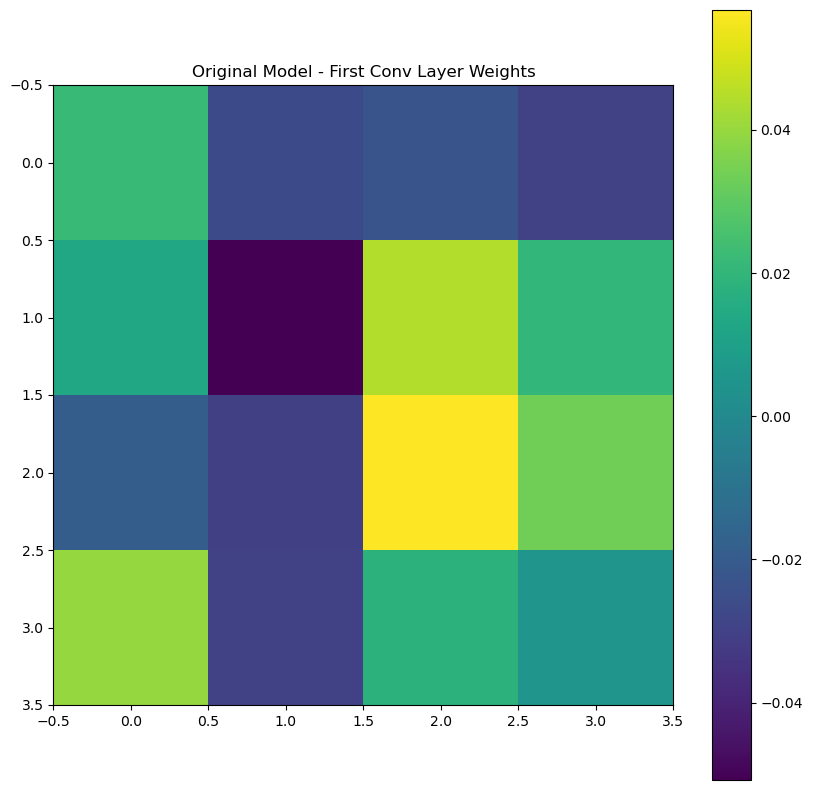

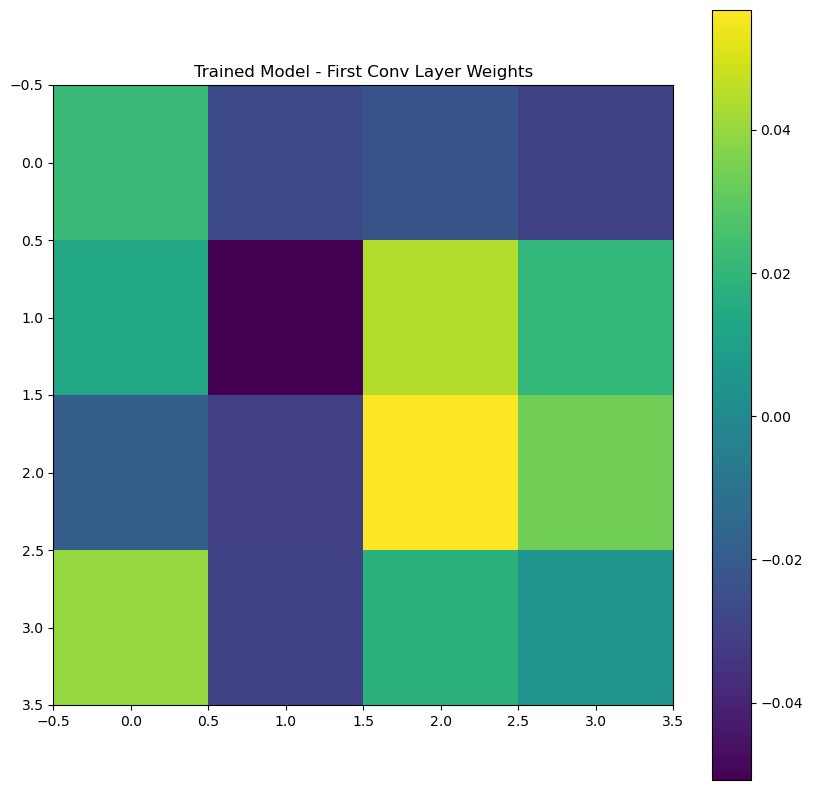

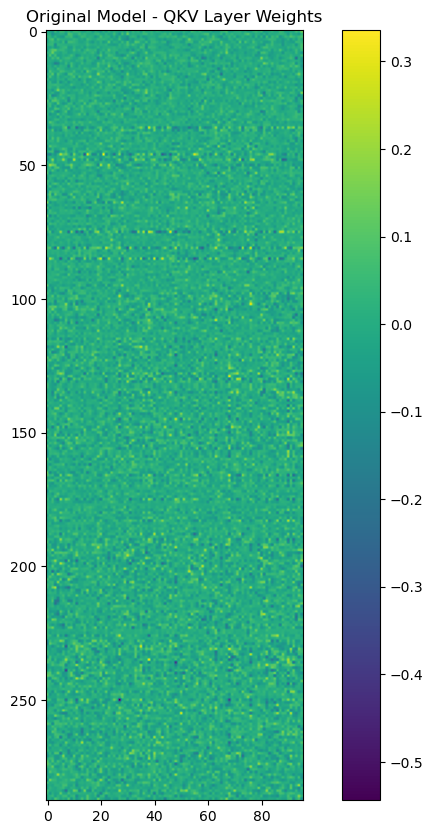

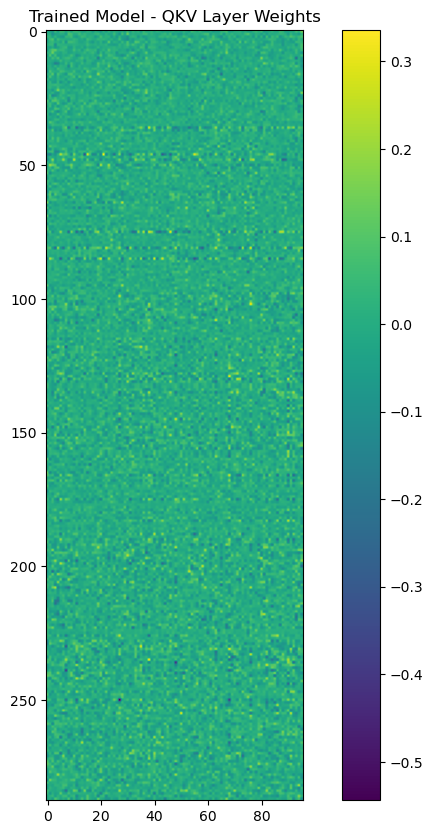

In [ ]:
# Extract weights of the first convolutional layer in the patch embedding
original_conv_weights = original_model.features[0][0].weight.data.cpu().numpy()
trained_conv_weights = trained_model.features[0][0].weight.data.cpu().numpy()

# Extract weights of the QKV layer in the first transformer block
original_qkv_weights = original_model.features[1][0].attn.qkv.weight.data.cpu().numpy()
trained_qkv_weights = trained_model.features[1][0].attn.qkv.weight.data.cpu().numpy()

# Check if the weights are equal
weights_equal = np.array_equal(original_conv_weights, trained_conv_weights)
print(f'Are the weights of the first convolutional layer equal? {weights_equal}')

# Calculate the difference
weights_difference = np.abs(original_conv_weights - trained_conv_weights)
max_difference = np.max(weights_difference)
print(f'Maximum difference between the weights: {max_difference}')

# Plot weights of the original model
def plot_weights(weights, title,name):
    plt.figure(figsize=(10, 10))
    if weights.ndim == 4:  # For convolutional layer weights
        plt.imshow(weights[0, 0], cmap='viridis')  # Visualize the first filter
    elif weights.ndim == 2:  # For QKV layer weights
        plt.imshow(weights, cmap='viridis')  # Visualize the weights
    plt.colorbar()
    plt.title(title)
    plt.savefig(name+'.png')
    plt.show()

plot_weights(original_conv_weights, 'Original Model - First Conv Layer Weights','ori1stcnn')
plot_weights(trained_conv_weights, 'Trained Model - First Conv Layer Weights','otr1stcnn')
plot_weights(original_qkv_weights, 'Original Model - QKV Layer Weights','oriqkv')
plot_weights(trained_qkv_weights, 'Trained Model - QKV Layer Weights','trqkv')


In [ ]:
for name, param in swinmodel.named_parameters():
    if param.requires_grad:
        print(name)

features.0.0.weight
features.0.0.bias
features.0.2.weight
features.0.2.bias
features.1.0.norm1.weight
features.1.0.norm1.bias
features.1.0.attn.logit_scale
features.1.0.attn.qkv.weight
features.1.0.attn.qkv.bias
features.1.0.attn.proj.weight
features.1.0.attn.proj.bias
features.1.0.attn.cpb_mlp.0.weight
features.1.0.attn.cpb_mlp.0.bias
features.1.0.attn.cpb_mlp.2.weight
features.1.0.norm2.weight
features.1.0.norm2.bias
features.1.0.mlp.0.weight
features.1.0.mlp.0.bias
features.1.0.mlp.3.weight
features.1.0.mlp.3.bias
features.1.1.norm1.weight
features.1.1.norm1.bias
features.1.1.attn.logit_scale
features.1.1.attn.qkv.weight
features.1.1.attn.qkv.bias
features.1.1.attn.proj.weight
features.1.1.attn.proj.bias
features.1.1.attn.cpb_mlp.0.weight
features.1.1.attn.cpb_mlp.0.bias
features.1.1.attn.cpb_mlp.2.weight
features.1.1.norm2.weight
features.1.1.norm2.bias
features.1.1.mlp.0.weight
features.1.1.mlp.0.bias
features.1.1.mlp.3.weight
features.1.1.mlp.3.bias
features.2.reduction.weight
fe

# Find Similarity

In [ ]:
# Extract features for the test set
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            images, label = data
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Create a DataLoader for the test set
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
test_features, test_labels = extract_features(swinmodel, test_loader, device)

In [ ]:
# Find the Most Similar Image in the Test Set
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar_image(input_image, model, test_features, test_labels, device):
    model.eval()
    with torch.no_grad():
        input_image = input_image.to(device).unsqueeze(0)
        input_feature = model(input_image).cpu().numpy()

    similarities = cosine_similarity(input_feature, test_features)
    most_similar_index = np.argmax(similarities)
    most_similar_image = test_features[most_similar_index]
    most_similar_label = test_labels[most_similar_index]

    return most_similar_image, most_similar_label

# Example usage
input_image, _ = dataset[0]  # Replace with your input image
most_similar_image, most_similar_label = find_most_similar_image(input_image, swinmodel, test_features, test_labels, device)
print(f'Most similar image label: {most_similar_label}')

In [ ]:
#Calculate Similarity Between Two Input Images
def calculate_similarity(image1, image2, model, device):
    model.eval()
    with torch.no_grad():
        image1 = image1.to(device).unsqueeze(0)
        image2 = image2.to(device).unsqueeze(0)
        feature1 = model(image1).cpu().numpy()
        feature2 = model(image2).cpu().numpy()

    similarity = cosine_similarity(feature1, feature2)
    return similarity[0][0]

# Example usage
image1, _ = dataset[0]  # Replace with your first input image
image2, _ = dataset[1]  # Replace with your second input image
similarity = calculate_similarity(image1, image2, swinmodel, device)
print(f'Similarity between the two images: {similarity}')